In [2]:
import os
import sys

In [3]:
from PIL import Image
import pytesseract

# Note, need to have tesseract installed to use pytesseract.

In [4]:
from typing import List

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

In [33]:
import re

In [45]:
test_filepath = '/Volumes/ja2/vegan/vegan_parser/test_data/labels/large_size_lotion_cropped.jpeg'


In [4]:
# Let's scope out the image first

In [5]:
# This will pop up in another window, not in line with the notebook.
# im = Image.open(test_filepath)
# im.show()  

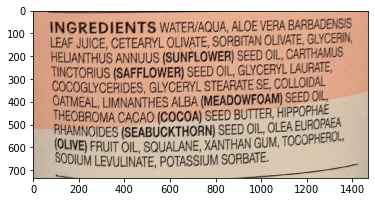

In [26]:
img=mpimg.imread(test_filepath)
plt.imshow(img)

In [46]:
text = str(((pytesseract.image_to_string(Image.open(test_filepath))))) 

In [47]:
text

'INGREDIENTS WATER/AQUA, ALOE VERA BARBADENSIS\nLEAF JUICE, CETEARYL OLIVATE, SORBITAN OLIVATE, GLYCERIN,\nHELIANTHUS ANNUUS (SUNFLOWER) SEED OIL, CARTHAMUS\nTINCTORIUS (SAFFLOWER) SEED OIL, GLYCERYL LAURATE,\nCOCOGLYCERIDES, GLYCERYL STEARATE SE, COLLOIDAL\nOATMEAL, LIMNANTHES ALBA (MEADOWFOAM) SEED OIL.\nTHEOBROMA CACAO (COCOA) SEED BUTTER, HIPPOPHAE\nRHAMNOIDES (SEABUCKTHORN) SEED OIL, OLEA EUROPAEA\n\n(OLIVE) FRUIT OIL, SQUALANE, XANTHAN GUM, TOCOPHEROL\n\nSODIUM LEVULINATE, POTASSIUM SORBATE.\n7 a Sa'

### Hey, looking pretty good!
The picture is fairly fuzzy, and there's a change in the background, but this captures all the text.
Interesting the way that character returns are handled, but we can hopefully use a "." as the ending. Unclear what's up with the last character.
When I run %timeit on this, it takes about 1.52 seconds to get a response (ouch!).
That's pretty slow, but that's okay for this work...at least for now.

### Let's test on a harder image.
This one has a shimmery background, and is printed on a flexible surface (it's from a sheet mask)

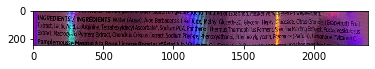

In [15]:
test_sparkle_fp = '/Volumes/ja2/vegan/vegan_parser/test_data/labels/sparkle_cropped.jpeg'
img=mpimg.imread(test_sparkle_fp)
plt.imshow(img)

In [16]:
text_sparkle = str(((pytesseract.image_to_string(Image.open(test_sparkle_fp))))) 
text_sparkle

'Mi Gluceth 20, Ghyeern Hepty ee Citrus Grandls (Grapefruit) Fruit\n|, Thermus Thermophillus Ferment, ‘oirulina Maxima ExtraGl, Fucus Vesiculosys\nenoxyethiand| Ethylnexyilycerin, Fragrance (Parfum), Limonene. “Vitamin ¢'

### Wow that is terrible!
It looks like tesseract is only picking up the right half of the ingredients list.

### And let's try another one.
This one has a handwritten-like font, and is printed on a curved surface.

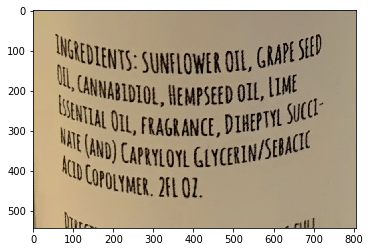

In [17]:
test_curve_fp = '/Volumes/ja2/vegan/vegan_parser/test_data/labels/curved_handfont_cropped.jpeg'
img=mpimg.imread(test_curve_fp)
plt.imshow(img)

In [18]:
text_curve = str(((pytesseract.image_to_string(Image.open(test_curve_fp))))) 
text_curve

'"totes: suman ot, CURES?\n-CNNAHTDTOL, NempseeD OIL, LIME (:\ni ACO, Face, bur\nip tM) Capeytoye Guycentn/SEH4C\n\n| “Monee 2101\n\nhoe wil'

### Yeah, ths one is not so good either. 

### How about curved but typed text -- this will be a common use case.


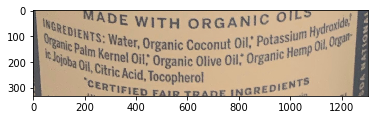

In [19]:
test_bronner_fp = '/Volumes/ja2/vegan/vegan_parser/test_data/labels/bronner_soap_cropped.jpeg'
img=mpimg.imread(test_bronner_fp)
plt.imshow(img)

In [20]:
text_bronner = str(((pytesseract.image_to_string(Image.open(test_bronner_fp))))) 
text_bronner

'nba'

In [ ]:
# wow, I guess it's really shitty with unprocessed curved images.
# So let's try a corrected version. I quickly & crudely edited this one by hand in GIMP

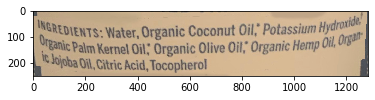

In [21]:
test_bronner_fp2 = '/Volumes/ja2/vegan/vegan_parser/test_data/labels/bronner_soap_cropped_edited.jpeg'
img=mpimg.imread(test_bronner_fp2)
plt.imshow(img)

In [22]:
text_bronner = str(((pytesseract.image_to_string(Image.open(test_bronner_fp))))) 
text_bronner

'= =\nNGREDIENTS: Water, Organic Coconut Oil,” Potassium Hydroxide\n\ntac Palm Kernel Oil? Organic Olive Oil,” Organic Hemp\n, “ojoba Oil, Citric Acid, Tocopherol'

In [ ]:
# A SIGNIFICANT improvement!
# But note there are still issues with reading.

#TODO: image pre-processing!
Especially to de-curve images.
Like they recommend: https://github.com/tesseract-ocr/tesseract/wiki/ImproveQuality

### I'll put image pre-processing aside for now, as we know the OCR approach works in theory and and for now people will just have to have good, clear images to provide to process.

# TEXT PROCESSING

#### Next step: 
Take the ingredients string output and convert into a list of strings of ingredients.

In [48]:
# our sample text
text

'INGREDIENTS WATER/AQUA, ALOE VERA BARBADENSIS\nLEAF JUICE, CETEARYL OLIVATE, SORBITAN OLIVATE, GLYCERIN,\nHELIANTHUS ANNUUS (SUNFLOWER) SEED OIL, CARTHAMUS\nTINCTORIUS (SAFFLOWER) SEED OIL, GLYCERYL LAURATE,\nCOCOGLYCERIDES, GLYCERYL STEARATE SE, COLLOIDAL\nOATMEAL, LIMNANTHES ALBA (MEADOWFOAM) SEED OIL.\nTHEOBROMA CACAO (COCOA) SEED BUTTER, HIPPOPHAE\nRHAMNOIDES (SEABUCKTHORN) SEED OIL, OLEA EUROPAEA\n\n(OLIVE) FRUIT OIL, SQUALANE, XANTHAN GUM, TOCOPHEROL\n\nSODIUM LEVULINATE, POTASSIUM SORBATE.\n7 a Sa'

In [49]:
text = text.replace('\n', ' ')
lower_text = text.lower()

In [50]:
lower_text

'ingredients water/aqua, aloe vera barbadensis leaf juice, cetearyl olivate, sorbitan olivate, glycerin, helianthus annuus (sunflower) seed oil, carthamus tinctorius (safflower) seed oil, glyceryl laurate, cocoglycerides, glyceryl stearate se, colloidal oatmeal, limnanthes alba (meadowfoam) seed oil. theobroma cacao (cocoa) seed butter, hippophae rhamnoides (seabuckthorn) seed oil, olea europaea  (olive) fruit oil, squalane, xanthan gum, tocopherol  sodium levulinate, potassium sorbate. 7 a sa'

In [32]:
# Let's remove "ingredients"...
# We'll want to remove that entire word plus any associated punctuation.
# so essentially, remove the characters that make up the word+punctuation that includes the word "ingredients"
# We'll use the regex library - remove matches of the word "ingredient" or "ingredient" plus characters afterwards
# and we'll also include any words in front of ingredients and remove those as well.

# Oh...but what if there's other words in front of ingredients? --> #TODO address this case (e.g. "our ingredients:")


In [51]:
re.sub('(^.*?)ingredients\S+|(^.*?)ingredients', '', "ingredients: water...")

' water...'

In [52]:
lower_text = re.sub('ingredients\S+|ingredients', '', lower_text)

In [53]:
lower_text

' water/aqua, aloe vera barbadensis leaf juice, cetearyl olivate, sorbitan olivate, glycerin, helianthus annuus (sunflower) seed oil, carthamus tinctorius (safflower) seed oil, glyceryl laurate, cocoglycerides, glyceryl stearate se, colloidal oatmeal, limnanthes alba (meadowfoam) seed oil. theobroma cacao (cocoa) seed butter, hippophae rhamnoides (seabuckthorn) seed oil, olea europaea  (olive) fruit oil, squalane, xanthan gum, tocopherol  sodium levulinate, potassium sorbate. 7 a sa'

### There's a few things we'll need to consider. More of an art than a science now.

#### Lower punctuation
I wonder if the commas will read as periods, and vice versa. I think it's really only those we need to look up.
So, we'll split ingredients on either periods or commas.
But, there may be that there is a period in the name of the ingredient. (e.g. spp. something something)
Hopefully this won't be an issue

#### Upper punctuation
There may be ingredients which have special designations (like organic status) which may have upper punctuation. For example in one of the images above, the organic indicator * was read by OCR as " .
It's tempting to just strip all the punctuation, but there may be some ingredients that include "'".
One option is to strip any "'" from the ingredients and store in our database that way but that's note very saisfying.
But...we could probably remove the last character if one exists, from 

#### After-ingredients list.
There may be portions after the ingredients that we won't want to include. (example: marker indicating what organic is.)




In [41]:
from string import punctuation

In [42]:
print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [ ]:
# split on either . or ,:

In [56]:
re.split('[.,]', lower_text)



[' water/aqua',
 ' aloe vera barbadensis leaf juice',
 ' cetearyl olivate',
 ' sorbitan olivate',
 ' glycerin',
 ' helianthus annuus (sunflower) seed oil',
 ' carthamus tinctorius (safflower) seed oil',
 ' glyceryl laurate',
 ' cocoglycerides',
 ' glyceryl stearate se',
 ' colloidal oatmeal',
 ' limnanthes alba (meadowfoam) seed oil',
 ' theobroma cacao (cocoa) seed butter',
 ' hippophae rhamnoides (seabuckthorn) seed oil',
 ' olea europaea  (olive) fruit oil',
 ' squalane',
 ' xanthan gum',
 ' tocopherol  sodium levulinate',
 ' potassium sorbate',
 ' 7 a sa']

In [ ]:
# Looking promising.

# Keep going... replace any repeated spaces with a single space, and strip leading/tailing spaces
# Also - how to deal with the parentheses? Need to compile the ingredient db/csv and see what it looks like.